<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Arcs-and-ODs" data-toc-modified-id="Arcs-and-ODs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Arcs and ODs</a></span><ul class="toc-item"><li><span><a href="#Arcs" data-toc-modified-id="Arcs-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Arcs</a></span></li><li><span><a href="#ODs" data-toc-modified-id="ODs-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>ODs</a></span></li></ul></li><li><span><a href="#Network-Graph" data-toc-modified-id="Network-Graph-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Network Graph</a></span><ul class="toc-item"><li><span><a href="#Create-graph" data-toc-modified-id="Create-graph-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Create graph</a></span></li><li><span><a href="#Find-shortest-paths" data-toc-modified-id="Find-shortest-paths-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Find shortest paths</a></span></li><li><span><a href="#Convert-lists-of-nodes-to-path-node-sequence" data-toc-modified-id="Convert-lists-of-nodes-to-path-node-sequence-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Convert lists of nodes to path-node sequence</a></span></li></ul></li></ul></div>

In [1]:
import os
import pandas as pd
import networkx as nx
from config import SCRATCH_FOLDER, INPUT_FOLDER
%matplotlib inline

## Arcs and ODs

### Arcs

In [24]:
arcs = pd.read_csv('../scratch/Arcs_with_lengths.csv')

In [25]:
arcs.head()

,arc_id,from_node_id,to_node_id,drive_dist_meters,drive_dist_km
0,1,1,76,9089,9
1,2,76,75,16778,17
2,3,75,2,21943,22
3,4,2,74,30458,30
4,5,74,73,2815,3


### ODs

In [26]:
od_tripcounts = pd.read_csv(os.path.join('../scratch/NodeNode_trips.csv'))

In [27]:
od_tripcounts.head()

,orig_node_id,dest_node_id,NodeNode_trips
0,13,18,40940.5
1,18,13,40940.5
2,12,13,3447.5
3,12,18,3447.5
4,25,13,245.0


## Network Graph

### Create graph

In [28]:
truck_network = nx.from_pandas_edgelist(arcs, 
                                        source='from_node_id', 
                                        target='to_node_id', 
                                        edge_attr=['arc_id','drive_dist_meters','drive_dist_km']
                                       )

In [29]:
truck_network[11][40]

{'arc_id': 17, 'drive_dist_km': 42, 'drive_dist_meters': 41960}

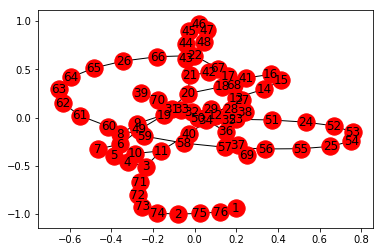

In [30]:
nx.draw_networkx(truck_network)

### Find shortest paths

In [31]:
paths = od_tripcounts[['orig_node_id', 'dest_node_id']]
paths['path_id'] = paths.index

In [32]:
paths.head()

,orig_node_id,dest_node_id,path_id
0,13,18,0
1,18,13,1
2,12,13,2
3,12,18,3
4,25,13,4


In [33]:
paths['node_list'] = paths.apply(lambda row: nx.shortest_path(truck_network, 
                                                             source=row['orig_node_id'], 
                                                             target=row['dest_node_id'], 
                                                             weight='drive_dist_meters'), axis=1)

In [34]:
paths.head()

,orig_node_id,dest_node_id,path_id,node_list
0,13,18,0,"[13, 18]"
1,18,13,1,"[18, 13]"
2,12,13,2,"[12, 13]"
3,12,18,3,"[12, 13, 18]"
4,25,13,4,"[25, 54, 53, 52, 24, 51, 23, 50, 19, 20, 18, 13]"


### Convert lists of nodes to path-node sequence

In [35]:
nodes_seq = paths\
                .apply(lambda row: pd.Series(row['node_list']), axis=1)\
                .stack()\
                .apply(int)\
                .to_frame(name='node_id')\
                .rename_axis(['path_id', 'node_seq'], axis='index')\
                .reset_index(level='node_seq')

In [36]:
nodes_seq.head(10)

,node_seq,node_id
path_id,,
0,0,13
0,1,18
1,0,18
1,1,13
2,0,12
2,1,13
3,0,12
3,1,13
3,2,18


In [37]:
paths_nodes = paths\
                .set_index('path_id')\
                .join(nodes_seq)\
                .drop('node_list', axis=1)

In [38]:
paths_nodes.head(10)

,orig_node_id,dest_node_id,node_seq,node_id
path_id,,,,
0,13,18,0,13
0,13,18,1,18
1,18,13,0,18
1,18,13,1,13
2,12,13,0,12
2,12,13,1,13
3,12,18,0,12
3,12,18,1,13
3,12,18,2,18


In [39]:
paths_nodes.to_csv('../scratch/Paths_nodes.csv')